### REI 603M - Assignment 1
#### Andri Freyr Viðarsson
In this notebook exploratory analysis is done on the Fake News dataset from kaggle, the dataset is available on https://www.kaggle.com/c/fake-news/data. The dataset consists of news articles and each article is labeled as either reliable or unreliable. Therefore the dataset is ideal for classification tasks. The data is raw, some feature engineering is necessary before training a classification model on the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
import time
from collections import Counter
from textblob import TextBlob
from langdetect import detect
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random

In [3]:
df = pd.read_csv('fake-news/train.csv')
# marked 1 if considered fake/unreliable news*

In [4]:
print(df.shape)
print(df.columns)
df.head(10)

(20800, 5)
Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [5]:
df['text'].nunique()

20386

In [6]:
df['text'].count()

20761

In [7]:
df.dropna(subset = ['text'], inplace = True)
df.drop_duplicates(subset = 'text', keep = 'first', inplace = True)

In [8]:
# is the data balanced
df['label'].value_counts()

0    10387
1     9999
Name: label, dtype: int64

The output above shows that the data is balanced and therefore it is not necessary to split the dataset prior to training a model.

In [9]:
print('Number of unique authors', df['author'].nunique())
print('Number of unique authors of false articles', df.loc[df['label'] == 1]['author'].nunique())
print('Number of unique authors of real articles', df.loc[df['label'] == 0]['author'].nunique())

Number of unique authors 4190
Number of unique authors of false articles 1970
Number of unique authors of real articles 2225


In [ ]:
# are all authors always fake
fake_authors = set()
real_authors = set()
mixed_authors = set()
cnt_both = 0
for index, row in df[['author', 'label']].iterrows():
    if isinstance(row['author'], str): # used for nan checking
        if row['label'] == 1:
            fake_authors.add(row['author'])
            if row['author'] in real_authors and row['author'] not in mixed_authors:
                mixed_authors.add(row['author'])
                print('.....')
                print(row['author'], row['label'], index)
        elif row['label'] == 0:
            real_authors.add(row['author'])
            if row['author'] in fake_authors and row['author'] not in mixed_authors:
                mixed_authors.add(row['author'])
                print('.....')
                print(row['author'], row['label'], index)
     


In [11]:
for a in mixed_authors:
    print(a)
    print(df.loc[df['author'] == a]['label'].value_counts())
    print('....')

Pamela Geller
1    3
0    1
Name: label, dtype: int64
....
AFP
0    2
1    1
Name: label, dtype: int64
....
Pam Key
0    242
1      1
Name: label, dtype: int64
....
Reuters
0    4
1    2
Name: label, dtype: int64
....
Ann Coulter
0    16
1     3
Name: label, dtype: int64
....


The previous output shows that some authors have written both legitimate and fake news articles

In [12]:
pd.set_option('display.max_colwidth', None)
df.loc[df['author'] == 'Reuters']

id  \
4759    4759   
8519    8519   
14292  14292   
15462  15462   
18022  18022   
18966  18966   

                                                                                               title  \
4759                                Regulator Tightens Control Over Wells Fargo - The New York Times   
8519            Harley-Davidson to Pay $12 Million Fine in Pollution Settlement - The New York Times   
14292                         Pope Francis Says Church Should Apologize to Gays - The New York Times   
15462                            Clinton campaign urges FBI to detail new developments in email case   
18022  2 Credit-Reporting Agencies Must Pay $23 Million for Deceptive Practices - The New York Times   
18966                             Concert plus campaign: Clinton turns to celebrities in homestretch   

        author  \
4759   Reuters   
8519   Reuters   
14292  Reuters   
15462  Reuters   
18022  Reuters   
18966  Reuters   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [13]:
# language detection
def detect_language(text):
    # tried useing textblob but too many requests
    try:
        return detect(text)
    except:
        return 'unknown'
df['language'] = df['text'].apply(lambda x: detect_language(x[:50]))
print(df['language'].value_counts())

en         19227
de           285
es           163
ru           156
fr            77
it            51
nl            49
af            46
no            42
ca            40
id            34
pt            25
ro            21
et            21
da            20
ar            19
unknown       17
tl            14
sv            14
hr            11
so             9
pl             8
tr             8
cy             6
sl             4
hu             3
fi             3
sw             3
vi             2
lt             2
sq             2
el             2
bg             1
zh-cn          1
Name: language, dtype: int64


The output above shows that almost all of the articles are in english. Next we examine the ratio between real and fake articles that are written in languages other than english

In [14]:
df_foreign = df.loc[df['language'] != 'en']
df_foreign['label'].value_counts()

1    904
0    255
Name: label, dtype: int64

The previous output shows that the data for foreign languages is clearly not balanced, there are much more fake articles in foregin langauages than real articles

In [15]:
df_foreign.groupby(['language', 'label']).size().reset_index(name='counts')

,language,label,counts
0,af,0,21
1,af,1,25
2,ar,1,19
3,bg,1,1
4,ca,0,17
5,ca,1,23
6,cy,0,1
7,cy,1,5
8,da,0,11
9,da,1,9


In [16]:
# text processing
df['text'].replace('\n', ' ', regex = True, inplace = True)
df["text"] = df['text'].str.replace('[^\w\s]',' ') # remove punctuation

In [17]:
df['title'].replace('\n', '', regex = True, inplace = True)
df["title"] = df['title'].str.replace('[^\w\s]','') # remove punctuation

In [18]:
# word counts
def title_len(title):
    if not isinstance(title, str): # used to handle NaN
        return 0

    return len(title.split())

df['text_word_count'] = df['text'].apply(lambda x: len(x.split())) # NaN already handeled
df['title_word_count'] = df['title'].apply(lambda x: title_len(x))
df.loc[df['author'] == 'Reuters']                                         

id  \
4759    4759   
8519    8519   
14292  14292   
15462  15462   
18022  18022   
18966  18966   

                                                                                            title  \
4759                              Regulator Tightens Control Over Wells Fargo  The New York Times   
8519            HarleyDavidson to Pay 12 Million Fine in Pollution Settlement  The New York Times   
14292                       Pope Francis Says Church Should Apologize to Gays  The New York Times   
15462                         Clinton campaign urges FBI to detail new developments in email case   
18022  2 CreditReporting Agencies Must Pay 23 Million for Deceptive Practices  The New York Times   
18966                           Concert plus campaign Clinton turns to celebrities in homestretch   

        author  \
4759   Reuters   
8519   Reuters   
14292  Reuters   
15462  Reuters   
18022  Reuters   
18966  Reuters   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [19]:
df_fake = df.loc[df['label'] == 1]
df_real = df.loc[df['label'] == 0]
print(df_real.shape, df_fake.shape)

(10387, 8) (9999, 8)


In the following chunks the word count of both the article title and the article text is analyzed

In [20]:
def get_percentiles(ls, percentiles):
    # params: list of percentiles and a list of numbers
    # returns: dict percentile: value
    out_dict = {}
    perc = np.percentile(ls,[1, 5, 10, 25, 50, 75, 90, 95, 99])
    for i, p in enumerate(perc):
        out_dict[f'{percentiles[i]}%'] = p
    return out_dict
        
p_list = [1, 5, 10, 25, 50, 75, 90, 95, 99]
all_titleLen_p = get_percentiles(df['title_word_count'], p_list)
fake_titleLen_p = get_percentiles(df_fake['title_word_count'], p_list)
real_titleLen_p = get_percentiles(df_real['title_word_count'], p_list)
print('All data',all_titleLen_p, '\n')
print('Fake News data', fake_titleLen_p, '\n')
print('Real News data',real_titleLen_p, '\n')

All data {'1%': 0.0, '5%': 5.0, '10%': 7.0, '25%': 9.0, '50%': 12.0, '75%': 14.0, '90%': 16.0, '95%': 17.0, '99%': 22.0} 

Fake News data {'1%': 0.0, '5%': 0.0, '10%': 5.0, '25%': 7.0, '50%': 10.0, '75%': 13.0, '90%': 16.0, '95%': 18.0, '99%': 25.0} 

Real News data {'1%': 7.0, '5%': 8.0, '10%': 9.0, '25%': 11.0, '50%': 13.0, '75%': 15.0, '90%': 16.0, '95%': 17.0, '99%': 19.0} 



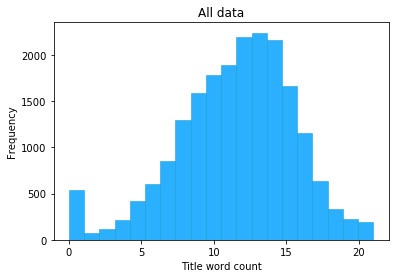

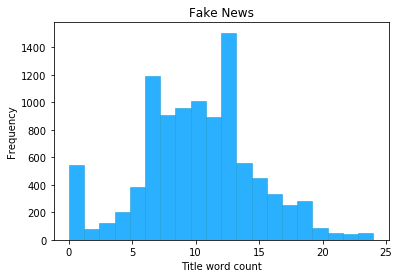

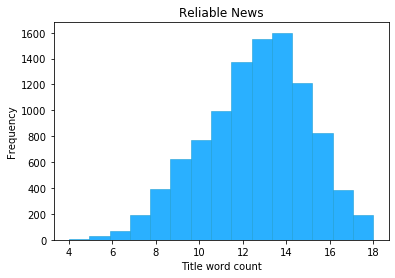

In [21]:
plt.hist(df['title_word_count'].loc[df['title_word_count'] < all_titleLen_p['99%']],
         bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('All data')
plt.xlabel('Title word count')
plt.ylabel('Frequency')
plt.show()

plt.hist(df_fake['title_word_count'].loc[df_fake['title_word_count'] < fake_titleLen_p['99%']],
         bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Fake News')
plt.xlabel('Title word count')
plt.ylabel('Frequency')
plt.show()

plt.hist(df_real['title_word_count'].loc[df_real['title_word_count'] < real_titleLen_p['99%']], 
        bins=15, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Reliable News')
plt.xlabel('Title word count')
plt.ylabel('Frequency')
plt.show()

The previous figures show that fake articles tend to have a shorter title and that articles with no titles are much more common among fake articles

In [22]:
all_textLen_p = get_percentiles(df['text_word_count'], p_list)
fake_textLen_p = get_percentiles(df_fake['text_word_count'], p_list)
real_textLen_p = get_percentiles(df_real['text_word_count'], p_list)
print('All data',all_textLen_p, '\n')
print('Fake News data', fake_textLen_p, '\n')
print('Real News data',real_textLen_p, '\n')

All data {'1%': 12.0, '5%': 52.0, '10%': 123.0, '25%': 273.0, '50%': 558.0, '75%': 1045.0, '90%': 1451.5, '95%': 1852.75, '99%': 3950.05000000001} 

Fake News data {'1%': 6.980000000000004, '5%': 26.0, '10%': 54.0, '25%': 178.0, '50%': 390.0, '75%': 794.0, '90%': 1385.2000000000007, '95%': 1943.2000000000007, '99%': 4084.100000000002} 

Real News data {'1%': 86.86, '5%': 163.0, '10%': 236.0, '25%': 396.0, '50%': 766.0, '75%': 1168.5, '90%': 1476.0, '95%': 1794.0, '99%': 3627.8199999999924} 



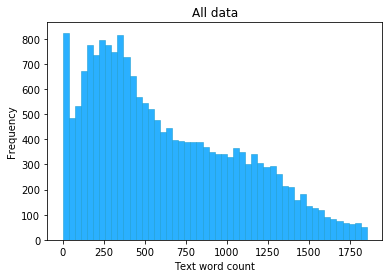

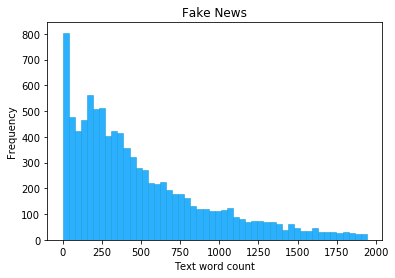

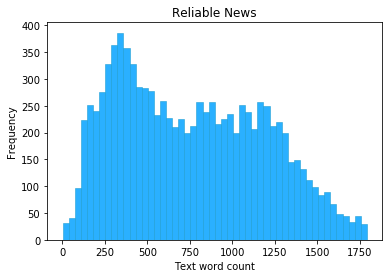

In [23]:
plt.hist(df['text_word_count'].loc[df['text_word_count'] < all_textLen_p['95%']],
         bins=50, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('All data')
plt.xlabel('Text word count')
plt.ylabel('Frequency')
plt.show()

plt.hist(df_fake['text_word_count'].loc[df_fake['text_word_count'] < fake_textLen_p['95%']],
         bins=50, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Fake News')
plt.xlabel('Text word count')
plt.ylabel('Frequency')
plt.show()

plt.hist(df_real['text_word_count'].loc[df_real['text_word_count'] < real_textLen_p['95%']], 
        bins=50, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Reliable News')
plt.xlabel('Text word count')
plt.ylabel('Frequency')
plt.show()

In [24]:
t1 = time.time()
def word_freq_counter(ls):
    # params: ls: a list of texts
    # returns: a Counter for words in all the texts, ordered in decreasing order
    # that is the most frequent word of the texts is first
    freq_count = Counter()
    for i in ls:
        for t in i.lower().split():
            freq_count[t] += 1
    return freq_count


all_title_counts = word_freq_counter(df.dropna(subset = ['title'])['title'])
fake_title_counts = word_freq_counter(df_fake.dropna(subset = ['title'])['title'])
real_title_counts = word_freq_counter(df_real.dropna(subset = ['title'])['title'])

print(all_title_counts.most_common(50), '\n')
print(fake_title_counts.most_common(50), '\n')
print(real_title_counts.most_common(50), '\n')


[('the', 11663), ('new', 7103), ('york', 6361), ('times', 6345), ('to', 5410), ('in', 3788), ('of', 3754), ('trump', 2954), ('a', 2916), ('for', 2404), ('breitbart', 2397), ('and', 2384), ('on', 2306), ('is', 1778), ('with', 1203), ('hillary', 1075), ('at', 1054), ('by', 1032), ('clinton', 1012), ('us', 963), ('donald', 872), ('from', 846), ('as', 829), ('after', 658), ('are', 649), ('will', 600), ('trumps', 581), ('not', 567), ('election', 562), ('it', 553), ('be', 549), ('over', 535), ('your', 525), ('what', 523), ('how', 519), ('news', 507), ('that', 502), ('you', 500), ('about', 479), ('russia', 450), ('this', 450), ('obama', 443), ('says', 413), ('video', 410), ('its', 392), ('war', 383), ('his', 382), ('an', 375), ('fbi', 368), ('have', 366)] 

[('the', 3357), ('to', 2536), ('of', 1862), ('in', 1601), ('a', 1186), ('and', 1170), ('trump', 1169), ('on', 1150), ('for', 1131), ('is', 968), ('hillary', 862), ('clinton', 775), ('by', 646), ('with', 532), ('us', 526), ('election', 445)

In [25]:
# identify words that are common in fake news_titles and not common in legitimate
def get_bla(counter1, counter2, top_n, factor):
    # params : counter1, counter2: Counter
    # top_n: threshold for top n most common items in counter 1
    # factor: integer scalar
    # returns: a list of items that are in most_common(top_n) of counter1 but are not in most_common(top_n*factor) of counter 2
    top_1_n = set([i[0] for i in counter1.most_common(top_n)])
    top_2_n = set([i[0] for i in counter2.most_common(top_n*factor)])
    out = list(top_1_n - top_2_n) # set difference
    return out

def get_intersect_n(counter1, counter2, top_n):
    top_1_n = set([i[0] for i in counter1.most_common(top_n)])
    top_2_n = set([i[0] for i in counter2.most_common(top_n)])
    return list(top_1_n.intersection(top_2_n))

print('The following words are among the top 50 most frequent words in both fake titles and and real titles\n')
print(get_intersect_n(fake_title_counts, real_title_counts, 50), '\n')

print('The following words are among the top 200 most frequent words in fake news article titles but are not among the top 800 most frequent words in real article titles\n')
print(get_bla(fake_title_counts, real_title_counts, 200, 4), '\n')

print('The following words are among the top 100 most frequent words in real news article titles but are not among the top 400 most frequent words in fake article titles\n')
print(get_bla(real_title_counts, fake_title_counts, 100, 4))

The following words are among the top 50 most frequent words in both fake titles and and real titles

['in', 'be', 'from', 'the', 'will', 'clinton', 'how', 'trump', 'by', 'donald', 'at', 'us', 'after', 'it', 'hillary', 'new', 'obama', 'news', 'on', 'a', 'for', 'is', 'as', 'are', 'not', 'you', 'and', 'with', 'over', 'that', 'of', 'what', 'your', 'to'] 

The following words are among the top 200 most frequent words in fake news article titles but are not among the top 800 most frequent words in real article titles

['leaked', 'breaking', 'comment', 'things', 'standing', 'november', 'americas', 'soros', 'pipeline', 're', 'в', 'dakota', 'water', 'hillarys', 'these', 'voting', 'caught', 'wikileaks', 'rock', 'gold', 'foundation', 'truthfeed', 'emails', 'reveals', 'voter', 'source', 'elections'] 

The following words are among the top 100 most frequent words in real news article titles but are not among the top 400 most frequent words in fake article titles

['border', 'briefing', 'breitbart'

Now the functions that were created in the code chunks above will be used for the full article texts

In [26]:
time_start = time.time()

all_text_counts = word_freq_counter(df['text'])
fake_text_counts = word_freq_counter(df_fake['text'])
real_text_counts = word_freq_counter(df_real['text'])

print(f'Elapsed time:{time.time()- time_start}')

Elapsed time:11.741155624389648


In [27]:
print(all_text_counts.most_common(100), '\n')
print(fake_text_counts.most_common(50), '\n')
print(real_text_counts.most_common(50), '\n')

[('the', 909691), ('to', 420303), ('of', 413241), ('and', 377801), ('a', 362994), ('in', 306774), ('that', 208380), ('is', 154990), ('for', 142792), ('on', 129199), ('it', 103687), ('with', 101364), ('was', 101063), ('as', 97574), ('he', 96948), ('said', 79610), ('by', 77268), ('are', 72786), ('at', 72541), ('have', 71862), ('be', 70661), ('his', 69031), ('not', 68264), ('this', 68057), ('from', 67761), ('mr', 66200), ('i', 66051), ('has', 63597), ('but', 61436), ('an', 60326), ('they', 59329), ('who', 54808), ('you', 51144), ('we', 47295), ('its', 46394), ('had', 45358), ('their', 44737), ('or', 44353), ('trump', 44108), ('about', 41766), ('were', 41220), ('will', 40858), ('she', 37289), ('one', 37170), ('would', 36896), ('more', 36807), ('been', 36678), ('her', 36395), ('people', 34931), ('which', 33461), ('all', 33416), ('if', 32145), ('what', 31991), ('when', 30439), ('new', 29562), ('there', 28401), ('out', 28141), ('so', 27045), ('no', 26031), ('can', 25906), ('like', 25695), ('u

In [28]:
print('The following words are among the top 50 most frequent words in both fake and and real news articles\n')
print(get_intersect_n(fake_text_counts, real_text_counts, 100), '\n')

print('The following words are among the top 200 most frequent words in fake news articles but are not among the top 400 most frequent words in real articles\n')
print(get_bla(fake_text_counts, real_text_counts, 200, 2), '\n')

print('The following words are among the top 100 most frequent words in real news articles but are not among the top 200 most frequent words in fake articles\n')
print(get_bla(real_text_counts, fake_text_counts, 100, 2))

The following words are among the top 50 most frequent words in both fake and and real news articles

['time', 'i', 'there', 'how', 'was', 'about', 'but', 'if', 'than', 'many', 'can', 'not', 'people', 'you', 'and', 'which', 'out', 'one', 'who', 'from', 'will', 'all', 'even', 'by', 'president', 'we', 'state', 'at', 'no', 'a', 'this', 'is', 'their', 'into', 'up', 'she', 'were', 'what', 'so', 'just', 'those', 'they', 'after', 'been', 'had', 'now', 'its', 'said', 'for', 'because', 'are', 'most', 'has', 'years', 'his', 'with', 'over', 'more', 'that', 'trump', 'to', 'other', 'in', 'be', 'the', 'would', 'them', 'my', 'states', 'it', 'he', 'or', 'new', 'only', 'on', 'some', 'as', 'like', 'when', 'do', 'our', 'an', 'also', 'could', 'of', 'her', 'have'] 

The following words are among the top 200 most frequent words in fake news articles but are not among the top 400 most frequent words in real articles

['fact', 'emails', 'clintons', 'syria', 'в', 'hillary', '2016', 'de', 'fbi', 'la', 'november

Next we attempt to visualize the data. That was done by constructing a 200 element histogram vector for each article text where element j is the proportional frequency of word j in the text. The 200 words for the histogram vector were selected by taking taking the 300 most freqeunt words in all the texts combined and omitting the 100 most frequent to avoid words such as 'a', 'is', 'the' and so on. Then dimension reduction is performed on the histogram vectors by using pca, the outcome from the pca was then plotted were fake articles are colored red.

In [36]:
# pca, data visualization
# take the

use_words = [i[0] for i in all_text_counts.most_common(300)][100:300]
article_histograms = np.zeros((df.shape[0], 200))
for index, row in enumerate(df['text']):
    words = row.split()
    try:
        word_freqs = [words.count(word)/len(words) for word in use_words]
        article_histograms[index] = word_freqs
    except:
        print(index)
        continue
    

82
892
4843
13650


In [38]:
X = StandardScaler().fit_transform(article_histograms)
pca = PCA(n_components=2)
pca.fit(X)
Xred = pca.transform(X)

....
'float' object has no attribute 'split'
8485
....
'float' object has no attribute 'split'
1865


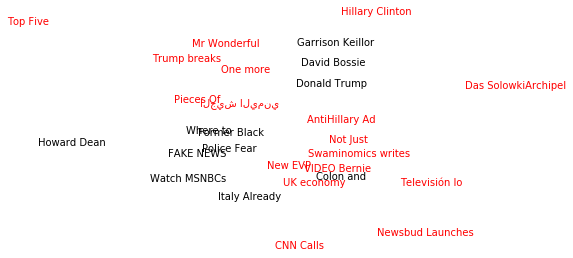

In [41]:
indices = random.sample(range(df.shape[0]), 30) # select 30 random items from df
fig = plt.figure(figsize = (1,1))
for i in indices:
    color = 'black'
    try:
        label = df['label'][i]
        title = ' '.join(df['title'][i].split()[:2])
        if label == 1:
            color = 'red'
        fig.text(Xred[i, 0], Xred[i, 1], title, color = color)
    except Exception as e:
        print('....')
        print(e)
        print(i)
        
plt.axis(False)
plt.show()